In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\sachur\AppData\Local\Temp\ipykernel_400\2515328079.py:105: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


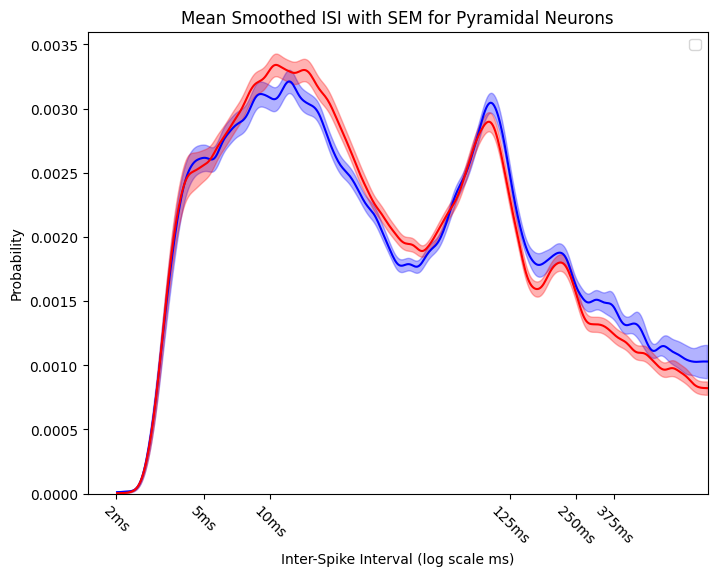

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')& (df_good['sub_population']=='deep')]

# Parameters from the MATLAB function
min_isi_param = 0.002  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 5
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

# Collect smoothed histograms for all neurons
isihist_sm_list = []
for t in df_py['spike_times']:
    # Compute inter-spike intervals (ISI)
    isi = np.diff(t)
    isi = isi[isi > 0]
    if len(isi) == 0:
        continue

    # Compute histogram with 'probability' normalization
    counts, _ = np.histogram(isi, bins=edges)
    isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
    #isihist = counts
    # Smooth the histogram
    isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
    isihist_sm_list.append(isihist_sm)

# Convert to array for mean and SEM calculation
isihist_sm_array = np.array(isihist_sm_list)
mean_isihist = np.mean(isihist_sm_array, axis=0)
sem_isihist = np.std(isihist_sm_array, axis=0) / np.sqrt(len(isihist_sm_array))
#sem_isihist = np.std(isihist_sm_array, axis=0)
# Plot mean curve with SEM shaded area
plt.figure(figsize=(8, 6))
plt.plot(time, mean_isihist, color='blue')
plt.fill_between(time, mean_isihist - sem_isihist, mean_isihist + sem_isihist, 
                 color='blue', alpha=0.3)

if log:
    plt.xscale('log')
    tick_positions = [0.002, 0.005, 0.01, .125, .25, .375]
    tick_labels = ['2ms','5ms','10ms', '125ms', '250ms', '375ms']
    plt.minorticks_off()


df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='deep')]


# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

# Collect smoothed histograms for all neurons
isihist_sm_list = []
for t in df_py['spike_times']:
    # Compute inter-spike intervals (ISI)
    isi = np.diff(t)
    isi = isi[isi > 0]
    if len(isi) == 0:
        continue

    # Compute histogram with 'probability' normalization
    counts, _ = np.histogram(isi, bins=edges)
    isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
    #isihist = counts
    # Smooth the histogram
    isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
    isihist_sm_list.append(isihist_sm)

# Convert to array for mean and SEM calculation
isihist_sm_array = np.array(isihist_sm_list)
mean_isihist = np.mean(isihist_sm_array, axis=0)
sem_isihist = np.std(isihist_sm_array, axis=0) / np.sqrt(len(isihist_sm_array))
#sem_isihist = np.std(isihist_sm_array, axis=0)

# Plot mean curve with SEM shaded area
plt.plot(time, mean_isihist, color='red')
plt.fill_between(time, mean_isihist - sem_isihist, mean_isihist + sem_isihist, 
                 color='red', alpha=0.3)


plt.xticks(tick_positions, tick_labels, rotation=-45)
plt.xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
plt.ylabel('Probability')
plt.title('Mean Smoothed ISI with SEM for Pyramidal Neurons')
plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.legend()
plt.show()

C:\Users\sachur\AppData\Local\Temp\ipykernel_400\11550640.py:104: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


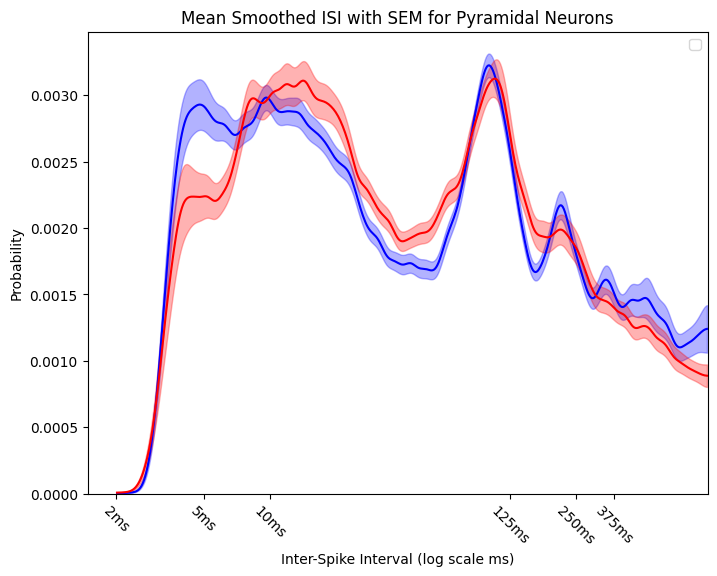

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')& (df_good['sub_population']=='superficial')]

# Parameters from the MATLAB function
min_isi_param = 0.002  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 5
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

# Collect smoothed histograms for all neurons
isihist_sm_list = []
for t in df_py['spike_times']:
    # Compute inter-spike intervals (ISI)
    isi = np.diff(t)
    isi = isi[isi > 0]
    if len(isi) == 0:
        continue

    # Compute histogram with 'probability' normalization
    counts, _ = np.histogram(isi, bins=edges)
    isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
    #isihist = counts
    # Smooth the histogram
    isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
    isihist_sm_list.append(isihist_sm)

# Convert to array for mean and SEM calculation
isihist_sm_array = np.array(isihist_sm_list)
mean_isihist = np.mean(isihist_sm_array, axis=0)
sem_isihist = np.std(isihist_sm_array, axis=0) / np.sqrt(len(isihist_sm_array))
#sem_isihist = np.std(isihist_sm_array, axis=0)
# Plot mean curve with SEM shaded area
plt.figure(figsize=(8, 6))
plt.plot(time, mean_isihist, color='blue')
plt.fill_between(time, mean_isihist - sem_isihist, mean_isihist + sem_isihist, 
                 color='blue', alpha=0.3)

if log:
    plt.xscale('log')
    tick_positions = [0.002, 0.005, 0.01, .125, .25, .375]
    tick_labels = ['2ms','5ms','10ms', '125ms', '250ms', '375ms']
    plt.minorticks_off()


df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='superficial')]

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

# Collect smoothed histograms for all neurons
isihist_sm_list = []
for t in df_py['spike_times']:
    # Compute inter-spike intervals (ISI)
    isi = np.diff(t)
    isi = isi[isi > 0]
    if len(isi) == 0:
        continue

    # Compute histogram with 'probability' normalization
    counts, _ = np.histogram(isi, bins=edges)
    isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
    #isihist = counts
    # Smooth the histogram
    isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
    isihist_sm_list.append(isihist_sm)

# Convert to array for mean and SEM calculation
isihist_sm_array = np.array(isihist_sm_list)
mean_isihist = np.mean(isihist_sm_array, axis=0)
sem_isihist = np.std(isihist_sm_array, axis=0) / np.sqrt(len(isihist_sm_array))
#sem_isihist = np.std(isihist_sm_array, axis=0)

# Plot mean curve with SEM shaded area
plt.plot(time, mean_isihist, color='red')
plt.fill_between(time, mean_isihist - sem_isihist, mean_isihist + sem_isihist, 
                 color='red', alpha=0.3)


plt.xticks(tick_positions, tick_labels, rotation=-45)
plt.xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
plt.ylabel('Probability')
plt.title('Mean Smoothed ISI with SEM for Pyramidal Neurons')
plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.legend()
plt.show()

C:\Users\sachur\AppData\Local\Temp\ipykernel_400\582594453.py:57: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max_isi_param)  # Set x-axis to start at 0


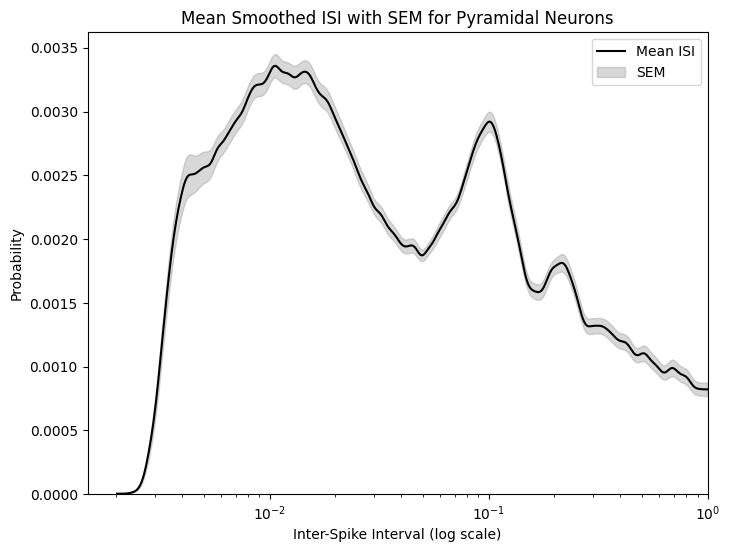

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='deep')]

# Parameters from the MATLAB function
min_isi_param = 0.002  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 4
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

# Collect smoothed histograms for all neurons
isihist_sm_list = []
for t in df_py['spike_times']:
    # Compute inter-spike intervals (ISI)
    isi = np.diff(t)
    isi = isi[isi > 0]
    if len(isi) == 0:
        continue

    # Compute histogram with 'probability' normalization
    counts, _ = np.histogram(isi, bins=edges)
    isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)

    # Smooth the histogram
    isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
    isihist_sm_list.append(isihist_sm)

# Convert to array for mean and SEM calculation
isihist_sm_array = np.array(isihist_sm_list)
mean_isihist = np.mean(isihist_sm_array, axis=0)
sem_isihist = np.std(isihist_sm_array, axis=0) / np.sqrt(len(isihist_sm_array))

# Plot mean curve with SEM shaded area
plt.figure(figsize=(8, 6))
plt.plot(time, mean_isihist, color='black', label='Mean ISI')
plt.fill_between(time, mean_isihist - sem_isihist, mean_isihist + sem_isihist, 
                 color='gray', alpha=0.3, label='SEM')

if log:
    plt.xscale('log')
plt.xlabel('Inter-Spike Interval (log scale)' if log else 'Inter-Spike Interval')
plt.ylabel('Probability')
plt.title('Mean Smoothed ISI with SEM for Pyramidal Neurons')
plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.legend()
plt.show()